# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Содержание проекта  <a class="anchor" id="0-bullet">
* [1. Подготовка данных](#1-bullet)
* [2. Исследование задачи](#2-bullet)
* [3. Борьба с дисбалансом](#3-bullet)
* [4. Тестирование модели](#4-bullet)
* [5. Общий вывод](#5-bullet)

# 1. Подготовка данных <a class="anchor" id="1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### Для начала импортируем данные из файла и посмотрим на них

In [1]:
# Импортируем данные и проанализируем их
import pandas as pd

data = pd.read_csv('/datasets/Churn.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [2]:
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3285,3286,15627220,Kang,735,Germany,Female,43,9.0,98807.45,1,0,0,184570.04,1
4925,4926,15790282,Trentino,817,Germany,Male,58,3.0,114327.59,2,1,1,42831.11,0
4953,4954,15684516,Plascencia,629,Spain,Male,34,1.0,121151.05,1,0,0,119357.93,0
3705,3706,15769645,Senior,612,France,Female,35,3.0,0.00,1,1,1,48108.72,0
8049,8050,15808868,Nwokeocha,652,France,Female,31,3.0,103696.97,3,0,0,155221.05,1
7826,7827,15647838,Davison,648,Germany,Female,51,2.0,116574.84,1,1,0,4121.04,1
6394,6395,15602845,Udinesi,466,Germany,Male,41,2.0,152102.18,2,1,0,181879.56,0
9037,9038,15792862,Blinova,653,Germany,Male,41,1.0,104584.11,1,1,0,15126.32,1
4008,4009,15612505,Joseph,835,Spain,Male,45,NaN,100212.13,1,1,0,152577.62,0
7728,7729,15637857,Woolacott,616,France,Female,31,8.0,0.00,1,0,1,76456.17,0


In [3]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [4]:
data.pivot_table(index = ['Exited'], values = ['IsActiveMember'], aggfunc = ['count'])

,count
,IsActiveMember
Exited,
0,7963
1,2037


## Результат первичного анализа данных: 

1. Есть ряд полей (ИД, фамилия и номер строки), которые для обучния модели не нужны и даже противопоказаны, т.к. имеют уникальные значения.
2. Есть категориальные переменные, которые необходимо преобразовать в логические ('Geography' и 'Gender')
3. В колонке 'Tenure' есть около 10% незаполненных значений.
4. Количество "положительных" значений (уходов клиентов) в выборке около 20%.

## Дальнейшие необходимые действия по подготовке данных для обучения моделей следующие:

1. Удалим поля, которые нам не нужны для обучения.
2. Преобразуем категориальные переменные методом прямого кодирования.
3. Заменим пропуски в колонке 'Tenure' методом IterativeImputer библиотеки sklearn на подходящие значения, зависимые от колонок: 'Geography', 'Gender', 'Age' и 'EstimatedSalary'. Для этого:
 - Возьмем часть датафрейма с этими колонками.
 - Преобразуем ее в массив.
 - Трансформирем его.
 - Заменим существующую колонку на рассчитанную.

In [8]:
data_dropped = data.drop(['RowNumber','CustomerId','Surname'], axis=1)
data_dropped.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
339,716,Germany,Female,39,10.0,115301.31,1,1,0,43527.40,1
9095,850,Germany,Female,38,2.0,102741.15,2,0,1,23974.85,0
5233,731,Germany,Female,49,4.0,88826.07,1,1,1,33759.41,1
5470,617,France,Male,25,1.0,102585.88,2,1,1,115387.40,0
3280,583,France,Female,57,3.0,238387.56,1,0,1,147964.99,1
9409,570,Spain,Male,34,10.0,0.00,2,0,1,183387.12,0
2053,850,France,Male,63,8.0,169832.57,1,0,0,184107.26,1
8121,793,France,Male,35,2.0,0.00,2,1,1,79704.12,0
2152,745,France,Female,55,9.0,110123.59,1,0,1,51548.14,1
4803,802,Spain,Male,41,5.0,0.00,2,1,1,134626.30,0


In [9]:
data_ohe = pd.get_dummies(data_dropped, drop_first=True)
data_ohe.sample(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
8560,627,28,5.0,71097.23,1,1,1,130504.49,0,1,0,1
4473,646,29,NaN,105957.44,1,1,0,15470.91,0,1,0,0
7304,679,58,8.0,125850.53,2,1,1,87008.17,0,1,0,1
316,559,49,2.0,147069.78,1,1,0,120540.83,1,0,0,1
5871,479,33,2.0,208165.53,1,0,0,50774.81,1,0,0,0
1548,668,25,8.0,0.00,2,1,1,135112.09,0,0,1,1
9930,425,40,9.0,166776.60,2,0,1,172646.88,0,1,0,1
9025,577,29,2.0,0.00,1,1,1,168924.41,0,0,1,1
2569,641,40,2.0,110086.69,1,1,0,159773.14,0,1,0,0
9427,693,39,0.0,0.00,2,0,0,81901.60,0,0,1,0


In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Сформируем массив для преобразования 
array_for_change = data_ohe[['Age','Tenure','EstimatedSalary','Geography_Germany', 'Geography_Spain', 'Gender_Male']].values

# Преобразуем массив
imp = IterativeImputer(max_iter=10, random_state=0)
array_transformed = imp.fit_transform(array_for_change)

# Перезапишем колонку
data_ohe['Tenure'] = array_transformed[:,1]

data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [15]:
data_ohe.sample(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
2587,563,33,4.986012,0.00,2,0,1,68815.05,0,0,0,1
3121,634,27,3.000000,107027.52,1,1,0,173425.68,0,1,0,1
8885,668,45,4.000000,102486.21,2,1,1,158379.25,0,0,1,1
9694,581,25,5.000000,77886.53,2,1,0,150319.49,0,0,0,1
1791,702,35,8.000000,14262.80,2,1,0,54689.16,0,0,1,0
3433,587,37,6.000000,104414.03,1,1,0,192026.02,0,1,0,0
6842,614,36,1.000000,118311.76,1,1,0,146134.68,0,0,0,1
3427,465,41,9.000000,117221.15,1,1,0,168280.95,0,0,0,1
5042,850,33,3.000000,0.00,2,1,1,11159.19,0,0,0,0
8101,581,43,5.000000,93259.57,3,1,0,141035.65,1,1,0,0


# 2. Исследование задачи<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### Все дальнейшие действия будем выполнять на уже подготовленном датасете 'data_oha':

1. Разделим датасет на целевой и прочие признаки.
2. Масштабируем числовые признаки.
3. Сформируем выборки в пропорции 60/20/20. Сначала выделим тестовую, потом оставшуюся поделим на тренировочную и валидационную.
4. Создадим сравнительную таблицу для анализа параметров обучаемых моделей.
5. Зададим изначально нулевое значение F1-метрики.
6. Рассчитаем F1-метрику на различных моделях и с различными параметрами на несбалансированной выборке. При каждом увеличении значения F1 по сравнению со значением предыдущей обученной модели будем добавлять строку с параметрами в общую сравнительную таблицу.
7. Выберем лучшую модель для дальнейшего обучения на сбалансированных данных.

In [16]:
# Разделим датасет на целевые и прочие признаки
from sklearn.preprocessing import StandardScaler

target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']

scaler = StandardScaler()
features[numeric] = scaler.fit_transform(features[numeric])

features.sample(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2693,0.118690,-0.469311,-1.086154,-1.225848,0.807737,0,1,-1.366653,0,0,1
188,-0.357262,-0.850726,0.000846,-1.225848,0.807737,0,1,1.669662,0,1,1
5338,0.667069,-0.469311,1.450181,0.413365,-0.911583,0,0,1.352209,1,0,0
2352,-0.139979,0.579578,-1.086154,1.305305,-0.911583,1,1,0.783274,0,1,0
5360,-0.181367,-0.373958,1.812514,-1.225848,0.807737,1,0,-0.598438,0,0,1
5046,1.474118,-1.327494,-0.723821,0.391505,-0.911583,0,0,-1.556498,0,1,1
9832,-0.574544,2.391296,-1.086154,0.468800,-0.911583,1,1,-0.176577,1,0,0
3937,1.143021,-1.232140,-1.448488,-1.225848,0.807737,1,1,1.727057,0,0,0
161,0.346319,-0.850726,-1.086154,-1.225848,0.807737,1,0,-0.288943,0,0,1
5153,0.460134,-0.946079,1.450181,-1.225848,0.807737,1,0,0.199542,0,0,0


In [17]:
from sklearn.model_selection import train_test_split

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345)

print(features_train.shape, end = ' '); print(target_train.shape)
print(features_valid.shape, end = ' '); print(target_valid.shape)
print(features_test.shape, end = ' '); print(target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


In [18]:
# Создадим датасет для записи сравнительных показателей
# model - наименование модели
# balance_type - вид балансировки модели
# balance_param - параметр балансировки модели
# model_param_name - название параметра для улучшения модели
# model_param_value - значение параметра для улучшения модели
# f1 - значение f1-меры
compare = {'model' : [],
           'balance_type' : [],
           'balance_param' : [],
           'model_param_name' : [],
           'model_param_value' : [],
           'f1' : [],
           'auc_roc' : []
           }

compare_data = pd.DataFrame(compare)

compare_data

,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc


In [19]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Установим текущее значение f1-меры в 0.
# В сравнительный датасет будем добавлять строку только в случае,
# если у новой модели f1 на валидационной выборке будет выше предыдущей 

f1_current = 0

# Функция расчета параметров модели и добавление их в сравнительный датасет
# target_income - целевой признак
# predicted_income - предсказанный признак
# compare_data_income - датасет для добавления строки
# model_name - наименование модели
# balance_type - вид балансировки модели
# balance_param - параметр балансировки модели
# model_param_name - название параметра для улучшения модели
# model_param_value - значение параметра для улучшения модели
# f1_income - входящее значение f1-меры

def count_model_params(target_income, 
                       predicted_income,
                       compare_data_income,
                       model_name,
                       balance_type,
                       balance_param,
                       model_param_name,
                       model_param_value,
                       f1_income,
                       auc_roc_income):

    f1_counted = f1_score(target_income, predicted_income)
    if (f1_counted > f1_income):
        compare_data_outcome = compare_data_income.append(
            pd.DataFrame([[model_name, 
            balance_type,
            balance_param, 
            model_param_name, 
            model_param_value, 
            f1_counted,
            auc_roc_income]], 
            columns = ['model', 
                       'balance_type',
                       'balance_param',
                       'model_param_name',
                       'model_param_value',
                       'f1',
                       'auc_roc']),
            ignore_index=True)
        
        return compare_data_outcome, f1_counted
    
    else:
        
        return compare_data_income, f1_income
        

In [20]:
from sklearn.metrics import roc_auc_score

# Функция расчета auc_roc
# model_income - модель, для которой рассчитываем значение метрики
# features_income - массив признаков для расчета
# target_income - массив целевых признаков для расчета

def count_auc_roc(model_income, 
                  features_income,
                  target_income):
    
    probabilities_valid = model_income.predict_proba(features_income)
    probabilities_one_valid = probabilities_valid[:, 1]

    return roc_auc_score(target_income, probabilities_one_valid)

In [21]:
# Логисчтическая регрессия

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

auc_roc_current = count_auc_roc(model, 
                                features_valid,
                                target_valid)

compare_data, f1_current = count_model_params(target_valid,
                                              predicted_valid,
                                              compare_data,
                                              'Логистическая регрессия',
                                              'Несбалансирована',
                                              '',
                                              '',
                                              '',
                                              f1_current,
                                              auc_roc_current)
compare_data

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333


In [22]:
# Решающее дерево

from sklearn.tree import DecisionTreeClassifier

for depth in range(1, 10):

    model = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=depth)
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)

    auc_roc_current = count_auc_roc(model, 
                                    features_valid,
                                    target_valid)
    
    compare_data, f1_current = count_model_params(target_valid,
                                                  predicted_valid,
                                                  compare_data,
                                                  'Решающее дерево',
                                                  'Несбалансирована',
                                                  '',
                                                  'max_depth',
                                                  depth,
                                                  f1_current,
                                                  auc_roc_current)
compare_data

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333
1,Решающее дерево,Несбалансирована,,max_depth,2,0.503704,0.739646
2,Решающее дерево,Несбалансирована,,max_depth,5,0.549689,0.822982
3,Решающее дерево,Несбалансирована,,max_depth,7,0.559242,0.823531


In [23]:
# Случайный лес

from sklearn.ensemble import RandomForestClassifier

for estimators in range(10, 100, 5):

    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=estimators)
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)

    auc_roc_current = count_auc_roc(model, 
                                    features_valid,
                                    target_valid)

    compare_data, f1_current = count_model_params(target_valid,
                                                  predicted_valid,
                                                  compare_data,
                                                  'Случайный лес',
                                                  'Несбалансирована',
                                                  '',
                                                  'n_estimators',
                                                  estimators,
                                                  f1_current,
                                                  auc_roc_current)
compare_data

,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333
1,Решающее дерево,Несбалансирована,,max_depth,2,0.503704,0.739646
2,Решающее дерево,Несбалансирована,,max_depth,5,0.549689,0.822982
3,Решающее дерево,Несбалансирована,,max_depth,7,0.559242,0.823531
4,Случайный лес,Несбалансирована,,n_estimators,35,0.560897,0.834042
5,Случайный лес,Несбалансирована,,n_estimators,45,0.564103,0.839409
6,Случайный лес,Несбалансирована,,n_estimators,50,0.565428,0.838622


## Вывод по результатам исследования задачи

Лучше всех на несбалансированной выборке себя показала модель **'Случайный лес'** с количеством деревьев - **50**. На ней удалось достигнуть значения метрики F1 - **0.565428**. Значение метрики **AUC-ROC** при этом также достаточно высокое - почти **0.84**.

# 3. Борьба с дисбалансом<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

Все дальнейшие действия мы будем выполнять с лучшей моделью - **'Случайный лес'**. Проведем различные мероприятия по уменьшению дисбаланса классов, и обучим на этих выборках модель с различными параметрами 'n_estimators'. 

*При каждом увеличении F1 по сравнению с предыдущей обученной модели будем добавлять строку с параметрами в общую сравнительную таблицу.*

Последовательность действий по борьбе с дисбалансом следующая:

1. Обучим модель с параметром "балансировки" классов.
2. Увеличим выборку и обучим модель.
3. Уменьшим выборку и обучим модель.
4. Если по результатам изменения выборки мы не получим целевого значения метрики f1 (более чем 0.59), проведем эксперименты с измененим порога классификации модели. 

In [24]:
# Случайный лес

for estimators in range(10, 100, 5):

    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=estimators, 
                                   class_weight='balanced')
    model.fit(features_train, target_train)

    predicted_valid = model.predict(features_valid)

    auc_roc_current = count_auc_roc(model, 
                                    features_valid,
                                    target_valid)

    compare_data, f1_current = count_model_params(target_valid,
                                                  predicted_valid,
                                                  compare_data,
                                                  'Случайный лес',
                                                  'class_weight',
                                                  '',
                                                  'n_estimators',
                                                  estimators,
                                                  f1_current,
                                                  auc_roc_current)
compare_data

,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333
1,Решающее дерево,Несбалансирована,,max_depth,2,0.503704,0.739646
2,Решающее дерево,Несбалансирована,,max_depth,5,0.549689,0.822982
3,Решающее дерево,Несбалансирована,,max_depth,7,0.559242,0.823531
4,Случайный лес,Несбалансирована,,n_estimators,35,0.560897,0.834042
5,Случайный лес,Несбалансирована,,n_estimators,45,0.564103,0.839409
6,Случайный лес,Несбалансирована,,n_estimators,50,0.565428,0.838622


In [25]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [19]:
# Случайный лес

for param in range(2, 10):

    features_upsampled, target_upsampled = upsample(features_train, target_train, param)
    
    for estimators in range(10, 100, 5):

        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=estimators)
        model.fit(features_upsampled, target_upsampled)

        predicted_valid = model.predict(features_valid)

        auc_roc_current = count_auc_roc(model, 
                                        features_valid,
                                        target_valid)

        compare_data, f1_current = count_model_params(target_valid,
                                                      predicted_valid,
                                                      compare_data,
                                                      'Случайный лес',
                                                      'Увеличение выборки',
                                                      param,
                                                      'n_estimators',
                                                      estimators,
                                                      f1_current,
                                                      auc_roc_current)

compare_data

,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333
1,Решающее дерево,Несбалансирована,,max_depth,2,0.503704,0.739646
2,Решающее дерево,Несбалансирована,,max_depth,5,0.549689,0.822982
3,Решающее дерево,Несбалансирована,,max_depth,7,0.559242,0.823531
4,Случайный лес,Несбалансирована,,n_estimators,35,0.560897,0.834042
5,Случайный лес,Несбалансирована,,n_estimators,45,0.564103,0.839409
6,Случайный лес,Несбалансирована,,n_estimators,50,0.565428,0.838622
7,Случайный лес,Увеличение выборки,2,n_estimators,15,0.569405,0.821670
8,Случайный лес,Увеличение выборки,2,n_estimators,20,0.570579,0.834368
9,Случайный лес,Увеличение выборки,2,n_estimators,30,0.578488,0.836368


In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [21]:
# Случайный лес

for param in range(10, 50, 5):

    features_downsampled, target_downsampled = downsample(features_train, target_train, param/100)

    for estimators in range(10, 100, 5):

        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=estimators)
        model.fit(features_downsampled, target_downsampled)

        predicted_valid = model.predict(features_valid)

        auc_roc_current = count_auc_roc(model, 
                                        features_valid,
                                        target_valid)

        compare_data, f1_current = count_model_params(target_valid,
                                                      predicted_valid,
                                                      compare_data,
                                                      'Случайный лес',
                                                      'Уменьшение выборки',
                                                      param/100,
                                                      'n_estimators',
                                                      estimators,
                                                      f1_current,
                                                      auc_roc_current)

compare_data

,model,balance_type,balance_param,model_param_name,model_param_value,f1,auc_roc
0,Логистическая регрессия,Несбалансирована,,,,0.301318,0.770333
1,Решающее дерево,Несбалансирована,,max_depth,2,0.503704,0.739646
2,Решающее дерево,Несбалансирована,,max_depth,5,0.549689,0.822982
3,Решающее дерево,Несбалансирована,,max_depth,7,0.559242,0.823531
4,Случайный лес,Несбалансирована,,n_estimators,35,0.560897,0.834042
5,Случайный лес,Несбалансирована,,n_estimators,45,0.564103,0.839409
6,Случайный лес,Несбалансирована,,n_estimators,50,0.565428,0.838622
7,Случайный лес,Увеличение выборки,2,n_estimators,15,0.569405,0.821670
8,Случайный лес,Увеличение выборки,2,n_estimators,20,0.570579,0.834368
9,Случайный лес,Увеличение выборки,2,n_estimators,30,0.578488,0.836368


## Вывод по результатам борьбы с дисбалансом данных

Мы применили несколько вариантов балансировки данных и обучили на них **модель 'Случайный лес' c различными значениями параметра 'n_estimators'**.

**Лучших результатов удалось достигнуть при уменьшении количества нулевых значений в выборке с коэффициентом 0.4. и количеством деревьев 20.** 

Обучние модели с этими параметрами дало **значение F1-метрики 0.597122** и достаточно хорошее значение **AUC-ROC - 0.839778**

При этом нам даже не понадобилось изменение порога классификации, мы получили целевое значение F1 без этого.

# 4. Тестирование модели<a class="anchor" id="4-bullet"></a>
👈[назад к оглавлению](#0-bullet)

*Ранее мы достигли целевого значния F1-метрики. Теперь необходимо проверить значение F1 на тестовой выборке и построить график AUC-ROC для выбранной модели.*

In [22]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

model = RandomForestClassifier(random_state=12345, 
                               n_estimators=20)

model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

predicted_test = model.predict(features_test)

f1_best = f1_score(target_test, predicted_test)

f1_best

0.6091825307950728

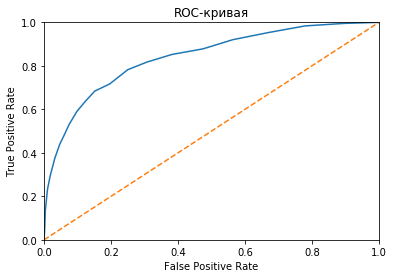

0.839587387277402

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая нашей модели
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc_current = roc_auc_score(target_test, probabilities_one_test)
auc_roc_current

# Общий вывод<a class="anchor" id="5-bullet"></a>
👈[назад к оглавлению](#0-bullet)



На тестовых данных удалось достигнуть значения метрики F1, удовлетворяющего нашим условиям.

**Итоговое значение F1 - 0.6092**

При этом мы наблюдаем достаточно высокое качество модели без увеличения порога классификации, о чем говорит график AUC-ROC

### Модель 'Случайный лес' cо значением параметра 'n_estimators' = 20 и обученная на сбалансированной выборке с коэффициентом уменьшения отрицательных ответов равным 0.4, наилучшая из возможных для обработки текущей клиентской базы и прогнозирования оттока клиентов.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*